In [1]:
import pyhf
import json
import copy
import jsonpatch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Download the Model

In [24]:
!curl -sL https://doi.org/10.17182/hepdata.89408.v1/r2  | tar -O -xzv RegionA/BkgOnly.json > lhood.json
!curl -sL https://doi.org/10.17182/hepdata.89408.v1/r2  | tar -O -xzv RegionA/patch.sbottom_750_745_60.json > patch.json

x RegionA/BkgOnly.json
x RegionA/patch.sbottom_750_745_60.json


## Helper Functions

In [25]:
def make_model(channel_list):
    spec = json.load(open('lhood.json'))
    patch = json.load(open('patch.json'))
    spec = jsonpatch.apply_patch(spec,patch)
    spec["channels"] = [c for c in spec["channels"] if c["name"] in channel_list]

    w = pyhf.Workspace(spec)
    m = w.model(
        measurement_name="NormalMeasurement",
        modifier_settings={
            "normsys": {"interpcode": "code4"},
            "histosys": {"interpcode": "code4p"},
        },
    )
    d = w.data(m)
    return w, m, d

def fitresults(constraints = None):
    _, m, d = make_model(['CRtt_meff'])

    pyhf.set_backend(pyhf.tensor.numpy_backend(),pyhf.optimize.minuit_optimizer(verbose = True))
    minuit = pyhf.optimizer._make_minuit(
        pyhf.utils.loglambdav,
        d,
        m,
        m.config.suggested_init(),
        m.config.suggested_bounds(),
        constraints
    )
    result = minuit.migrad(ncall = 100000)
    bestfit = pyhf.tensorlib.astensor([x[1] for x in minuit.values.items()])
    errors = pyhf.tensorlib.astensor([x[1] for x in minuit.errors.items()])

    return m,d,bestfit,errors


## Calculate per-parameter Impact

In [26]:
def calc_impact(idx,b,e,i,w,poi_index):
    _,_,bb,ee = fitresults({idx: b+e})
    poi_up_post = bb[poi_index]

    _,_,bb,ee = fitresults({idx: b-e})
    poi_dn_post = bb[poi_index]

    _,_,bb,ee = fitresults({idx: b+w})
    poi_up_pre = bb[poi_index]

    _,_,bb,ee = fitresults({idx: b-w})
    poi_dn_pre = bb[poi_index]
    return np.asarray([poi_dn_post,poi_up_post,poi_dn_pre,poi_up_pre])

def get_impact_data():
    m,_,b,e = fitresults()
    widths = pyhf.tensorlib.concatenate([
        m.config.param_set(k).width() for k,v in m.config.par_map.items() if m.config.param_set(k).constrained
    ])
    initv = pyhf.tensorlib.concatenate([
        m.config.param_set(k).suggested_init for k,v in m.config.par_map.items() if m.config.param_set(k).constrained
    ])
    labels = np.asarray(['{}[{:02}]'.format(k,i) if m.config.param_set(k).n_parameters > 1 else k  for k in m.config.par_order  if m.config.param_set(k).constrained for i in range(m.config.param_set(k).n_parameters)])
    poi_free = b[m.config.poi_index]
    impacts = []
    
    for i,w in enumerate(widths):
        if i==m.config.poi_index:
            continue
        print(i)
        impct = calc_impact(i,b[i],e[i],w,initv[i],m.config.poi_index)
        impacts.append(impct-poi_free)
    return np.asarray(impacts),labels
        

impacts,labels = get_impact_data()

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


## Make the plot!

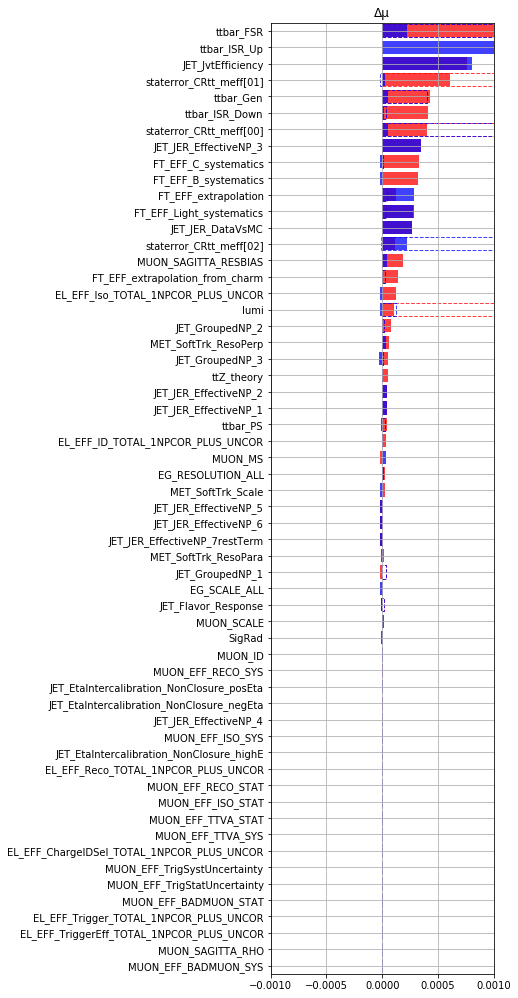

In [29]:
impcord  = np.argsort(np.max(np.abs(impacts[:,:2]),axis=1))
simpacts = impacts[impcord]
slabels   = labels[impcord]
plt.barh(range(len(simpacts)),np.asarray(simpacts)[:,0], alpha = 0.75, linestyle='dashed', facecolor = 'r')
plt.barh(range(len(simpacts)),np.asarray(simpacts)[:,1], alpha = 0.75, linestyle='dashed', facecolor = 'b')
plt.barh(range(len(simpacts)),np.asarray(simpacts)[:,2], alpha = 0.75, linestyle='dashed', fill=None, edgecolor = 'r')
plt.barh(range(len(simpacts)),np.asarray(simpacts)[:,3], alpha = 0.75, linestyle='dashed', fill=None, edgecolor = 'b')
plt.xlim(-.001,.001)
plt.ylim(-0.5,len(simpacts)-0.5)
plt.gcf().set_size_inches(4,17.5)
plt.title('Δµ')
plt.yticks(range(len(slabels)),slabels)
plt.grid()